In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import io
import os

In [2]:
df = pd.read_csv("Final_Marks_Data.csv")

In [3]:
X = df.drop(['Student_ID', 'Final Exam Marks (out of 100)'], axis=1)
y = df['Final Exam Marks (out of 100)']

In [4]:
X

,Attendance (%),Internal Test 1 (out of 40),Internal Test 2 (out of 40),Assignment Score (out of 10),Daily Study Hours
0,84,30,36,7,3
1,91,24,38,6,3
2,73,29,26,7,3
3,80,36,35,7,3
4,84,31,37,8,3
...,...,...,...,...,...
1995,82,31,28,6,2
1996,78,38,27,7,2
1997,78,30,33,9,2
1998,82,29,40,8,3


In [5]:
y

0       72
1       56
2       56
3       74
4       66
        ..
1995    52
1996    57
1997    61
1998    59
1999    64
Name: Final Exam Marks (out of 100), Length: 2000, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
scaler = StandardScaler()

In [8]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.shape

(1600, 5)

In [10]:
X_test_scaled.shape

(400, 5)

In [ ]:
# Convert numpy arrays to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1) # unsqueeze for (N, 1) shape
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [ ]:
# Create PyTorch Dataset and DataLoader
BATCH_SIZE = 16
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Define the PyTorch Model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        # Keras Layers: Dense(64, relu) -> Dense(32, relu) -> Dropout(0.2) -> Dense(1)
        self.layer_1 = nn.Linear(input_size, 64)
        self.relu_1 = nn.ReLU()
        self.layer_2 = nn.Linear(64, 32)
        self.relu_2 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu_1(self.layer_1(x))
        x = self.relu_2(self.layer_2(x))
        x = self.dropout(x)
        x = self.output_layer(x) # Output layer has no activation for regression
        return x

In [14]:
INPUT_SIZE = X_train_scaled.shape[1]
model = RegressionModel(INPUT_SIZE)

In [15]:
model

RegressionModel(
  (layer_1): Linear(in_features=5, out_features=64, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (relu_2): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
# optimizer='adam', loss='mse'
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [17]:
EPOCHS = 100
history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}

In [ ]:
# Simple function to split training data for validation_split=0.2
# Note: PyTorch typically uses separate DataLoaders, but we'll mimic the Keras split logic
# First, split the training tensor into train and validation sets
train_len = int(0.8 * len(X_train_tensor))
val_len = len(X_train_tensor) - train_len
train_subset, val_subset = torch.utils.data.random_split(train_data, [train_len, val_len])

In [19]:
train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False)

In [24]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_mae += mean_absolute_error(targets.cpu().detach().numpy(), outputs.cpu().detach().numpy()) * inputs.size(0)
        epoch_loss = running_loss / train_len
    epoch_mae = running_mae / train_len
    history['loss'].append(epoch_loss)
    history['mae'].append(epoch_mae)
    
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            val_mae += mean_absolute_error(targets.cpu().numpy(), outputs.cpu().numpy()) * inputs.size(0)
            
    val_loss /= val_len
    val_mae /= val_len
    history['val_loss'].append(val_loss)
    history['val_mae'].append(val_mae)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 10/100, Loss: 92.4238, Val Loss: 24.7741
Epoch 20/100, Loss: 90.8183, Val Loss: 26.9075
Epoch 30/100, Loss: 87.3429, Val Loss: 26.0690
Epoch 40/100, Loss: 85.3159, Val Loss: 25.8063
Epoch 50/100, Loss: 92.8038, Val Loss: 25.3131
Epoch 60/100, Loss: 90.6637, Val Loss: 25.7669
Epoch 70/100, Loss: 96.6920, Val Loss: 25.1537
Epoch 80/100, Loss: 87.5761, Val Loss: 25.9915
Epoch 90/100, Loss: 83.0653, Val Loss: 25.7003
Epoch 100/100, Loss: 87.8692, Val Loss: 23.7401


In [ ]:
# Evaluation on Test Set 
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    test_loss = criterion(y_pred_tensor, y_test_tensor).item()

In [ ]:
# Convert back to numpy for metric calculation
predictions = y_pred_tensor.cpu().numpy().flatten()
y_test_np = y_test_tensor.cpu().numpy().flatten()

test_mae = mean_absolute_error(y_test_np, predictions)
r2 = r2_score(y_test_np, predictions)

In [27]:
print(f"\nTest Set Mean Absolute Error: {test_mae:.2f} Marks")
print(f"Test Set Loss (MSE): {test_loss:.2f}")


Test Set Mean Absolute Error: 3.73 Marks
Test Set Loss (MSE): 22.45


In [28]:
comparison = pd.DataFrame({'Actual': y_test_np, 'Predicted': predictions})
print("\nSample Predictions vs Actual:")
print(comparison.head())


Sample Predictions vs Actual:
   Actual  Predicted
0    64.0  64.389465
1    52.0  54.395996
2    61.0  63.985085
3    54.0  46.789902
4    37.0  38.880447


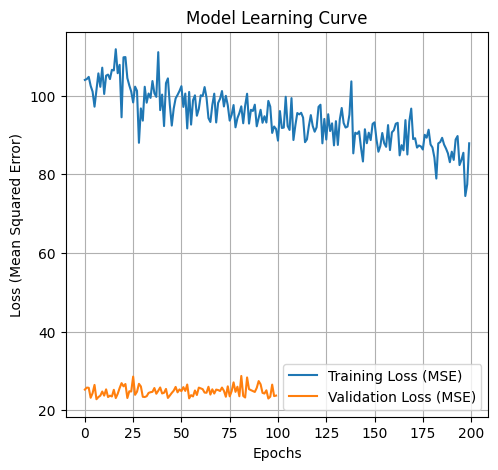

In [29]:
plt.figure(figsize=(12, 5))

# Plot Learning Curve
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss (MSE)')
plt.plot(history['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)

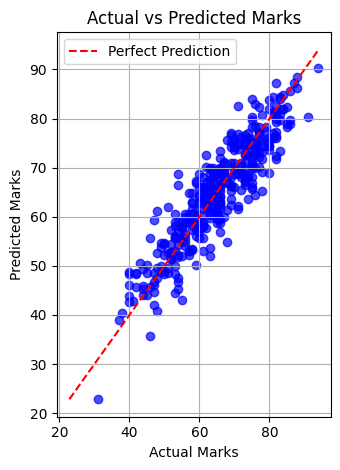

In [30]:
plt.subplot(1, 2, 2)
plt.scatter(y_test_np, predictions, alpha=0.7, color='blue')
# Draw a perfect prediction line (x=y)
limits = [min(y_test_np.min(), predictions.min()), max(y_test_np.max(), predictions.max())]
plt.plot(limits, limits, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Marks')
plt.xlabel('Actual Marks')
plt.ylabel('Predicted Marks')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
new_student_data = np.array([[85, 30, 32, 8, 3]])
new_student_scaled = scaler.transform(new_student_data)
new_student_tensor = torch.tensor(new_student_scaled, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predicted_mark_tensor = model(new_student_tensor)
    
predicted_mark = predicted_mark_tensor.cpu().numpy().flatten()[0]

c:\Users\Rayquaza\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [32]:
print("\n" + "="*40)
print(f"Prediction for Hypothetical Student:\nInputs: {new_student_data}")
print(f"Predicted Final Exam Score: {predicted_mark:.2f}")
print("="*40)


Prediction for Hypothetical Student:
Inputs: [[85 30 32  8  3]]
Predicted Final Exam Score: 64.10


In [33]:
print(f"\nTest Set Mean Squared Error (MSE): {test_loss:.2f}")
print(f"Test Set R^2 Score: {r2*100:.2f}%")


Test Set Mean Squared Error (MSE): 22.45
Test Set R^2 Score: 82.07%
